In [3]:
import torchvision
import torch
import os
import random
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [4]:
from torchvision.datasets.utils import download_and_extract_archive
from torchvision.datasets.folder import ImageFolder

In [5]:
data_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

In [6]:
if not os.path.exists("/home/23dcs505/data/2750"):
    print("No dataset found")
fulldata=ImageFolder(root='/home/23dcs505/data/2750', transform=data_transform)


In [7]:
from torch.utils.data import random_split

train_len=int((0.8)*len(fulldata))
test_len=len(fulldata)-(train_len)

train_data_set,test_data_set= random_split(fulldata,[train_len, test_len])

In [8]:
all_list=[0,1,2,3,4,5,6,7,8,9]

In [9]:
train_class_len=5

In [10]:
train_list=random.sample(all_list,train_class_len)
test_list=list(range(0,10))
strict_test_list=list(set(all_list) - set(train_list))


In [11]:
print(train_list)
print(test_list)
print(strict_test_list)

[1, 0, 3, 7, 5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[2, 4, 6, 8, 9]


In [12]:
ways=3
shots=5
queries=5
strict_ways=ways
gpu_num=2

In [13]:
from torch.utils.data import Subset

In [14]:
train_data_set.indices[0]

24065

In [15]:
def class_sorting(dataset, class_list):
    targets = dataset.dataset.targets

    indices= [i for i in dataset.indices if targets[i] in class_list]
    return Subset(dataset.dataset, indices)
    

In [16]:
train_data=class_sorting(train_data_set,train_list)
test_data=class_sorting(test_data_set,test_list)
strict_test_data=class_sorting(test_data_set,strict_test_list)

In [17]:
train_data[0]

(tensor([[[ 0.0056,  0.0056, -0.0116,  ..., -0.8849, -0.8678, -0.8678],
          [ 0.0056,  0.0056, -0.0116,  ..., -0.8849, -0.8678, -0.8678],
          [-0.0116, -0.0116, -0.0287,  ..., -0.8849, -0.8678, -0.8678],
          ...,
          [-0.7137, -0.7137, -0.7137,  ..., -0.4054, -0.4739, -0.4739],
          [-0.6794, -0.6794, -0.6794,  ..., -0.4911, -0.5938, -0.5938],
          [-0.6794, -0.6794, -0.6794,  ..., -0.4911, -0.5938, -0.5938]],
 
         [[ 0.1176,  0.1176,  0.1176,  ..., -0.4251, -0.4076, -0.4076],
          [ 0.1176,  0.1176,  0.1176,  ..., -0.4251, -0.4076, -0.4076],
          [ 0.1176,  0.1176,  0.1176,  ..., -0.4251, -0.4076, -0.4076],
          ...,
          [-0.2500, -0.2500, -0.2500,  ..., -0.2150, -0.2850, -0.2850],
          [-0.2150, -0.2150, -0.2150,  ..., -0.3025, -0.4076, -0.4076],
          [-0.2150, -0.2150, -0.2150,  ..., -0.3025, -0.4076, -0.4076]],
 
         [[ 0.2522,  0.2522,  0.2696,  ..., -0.0441, -0.0267, -0.0267],
          [ 0.2522,  0.2522,

In [ ]:
train_data.dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: /home/23dcs505/data/2750
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
train_data.indices[0]

19825

In [20]:
def mask_patches_tensor(image, patch_size=9, num_patches=124):
    masked = image.clone()
    _, H, W = masked.shape

    for _ in range(num_patches):
        top = torch.randint(0, H - patch_size + 1, (1,)).item()
        left = torch.randint(0, W - patch_size + 1, (1,)).item()
        masked[:, top:top + patch_size, left:left + patch_size] = 0.0 

    return masked

In [ ]:
from torch.utils.data import Dataset

class create_dataset(Dataset):
    def __init__(self,data,way,shot,query,episode):
        super().__init__()
        self.data=data
        self.way=way
        self.shot=shot
        self.query=query
        self.episode=episode

        self.class_to_indices=self._build_class_index()
        self.classes=list(self.class_to_indices.keys())
    
    @staticmethod
    def block_mask(img, patch_size=8, mask_ratio=0.1):
        C, H, W = img.shape
        num_patches_h = H // patch_size
        num_patches_w = W // patch_size
        total_patches = num_patches_h * num_patches_w
        num_mask = int(mask_ratio * total_patches)

        # Choose random patch indices to mask
        patch_indices = [(i, j) for i in range(num_patches_h) for j in range(num_patches_w)]
        masked_indices = random.sample(patch_indices, num_mask)

        mask = torch.zeros((1, H, W))

        for i, j in masked_indices:
            h_start = i * patch_size
            w_start = j * patch_size
            mask[:, h_start:h_start+patch_size, w_start:w_start+patch_size] = 1.0

        masked_img = img.clone() * (1 - mask)
        return masked_img, mask    

    def _build_class_index(self):
        class_index={}

        targets=self.data.dataset.targets

        labels = [self.data.dataset.targets[i] for i in self.data.indices]
        


        for indexofsubset, indexoforiginal in enumerate(self.data.indices):
            label=targets[indexoforiginal]
            if label not in class_index:
                class_index[label]=[]
            class_index[label].append(indexofsubset)

        return class_index
        
    def __len__(self):
            return self.episode
        
    def __getitem__(self, idx):
        selected_class=random.sample(self.classes,self.way)

        reconstruct_images, support_images, support_labels=[],[],[]
        query_images, query_labels=[],[]
        mask=[]


        label_map={class_name: i for i, class_name in enumerate(selected_class)}

        for class_name in selected_class:
            all_indices_for_class=self.class_to_indices[class_name]

            selected_index=random.sample(all_indices_for_class,self.shot+self.query)

            support_index=selected_index[:self.shot]
            query_index=selected_index[self.shot:]

            for i in support_index:
                image,_=self.data[i]
                support_images.append(image)

                masked_image,masks = self.block_mask(image)
                reconstruct_images.append(masked_image)
                mask.append(masks)
                support_labels.append(torch.tensor(label_map[class_name]))
                
            for i in query_index:
                image,_=self.data[i]
                query_images.append(image)
                query_labels.append(torch.tensor(label_map[class_name]))
            
        return(
            torch.stack(reconstruct_images),
            torch.stack(mask),
            torch.stack(support_images),
            torch.stack(support_labels),
            torch.stack(query_images),
            torch.stack(query_labels)
        )

In [ ]:
def compute_prototypes(support_embeddings,support_labels,way):
    embedding_dimensions=support_embeddings.size(-1)
    prototypes=torch.zeros(way,embedding_dimensions).to(support_embeddings.device)

    for c in range(way):
        class_mask=(support_labels==c)
        class_embeddings=support_embeddings[class_mask]
        prototypes[c]=class_embeddings.mean(dim=0)
    return prototypes

def classify_queries(prototypes,query_embeddings):
    n_query=query_embeddings.size(0)
    way=prototypes.size(0)

    query_exp=query_embeddings.unsqueeze(1).expand(n_query,way,-1)
    prototypes_exp=prototypes.unsqueeze(0).expand(n_query,way,-1)

    distances=torch.sum((query_exp-prototypes_exp)**2,dim=2)

    logits=-distances
    return logits

In [23]:
import torch.optim as optim

few_dataset=create_dataset(
    data=train_data,
    way=ways,
    shot=shots,
    query=queries,
    episode=200
)

In [ ]:
few_dataloader=DataLoader(
    few_dataset,
    shuffle=True,
    num_workers=8, 
    pin_memory=True
)

In [25]:
import torch
import torch.nn as nn
import torchvision.models as models

In [27]:
test_dataset=create_dataset(
    data=test_data,
    way=ways,
    shot=shots,
    query=queries,
    episode=200
)

In [28]:
test_dataloader=DataLoader(
    test_dataset,
    shuffle=True,
    num_workers=8, 
    pin_memory=True
)

In [29]:
print("testing on class :",test_list)

testing on class : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [30]:
strict_test_dataset=create_dataset(
    data=strict_test_data,
    way=strict_ways,
    shot=shots,
    query=queries,
    episode=200
)

In [ ]:
strict_test_dataloader=DataLoader(
    strict_test_dataset,
    shuffle=True,
    num_workers=8, 
    pin_memory=True
)

**RGFS Protypical Network**

In [ ]:
import torch
import gc

gc.collect()

torch.cuda.empty_cache()

In [33]:
from dropblock import DropBlock2D

In [34]:
from torch.cuda.amp import autocast, GradScaler

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class DropBlock2D(nn.Module):
    def __init__(self, drop_prob=0.1, block_size=3):
        super().__init__()
        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        else:
            gamma = self._compute_gamma(x)
            mask = (torch.rand(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device) < gamma).float()
            mask = self._compute_block_mask(mask)
            countM = mask.numel()
            count_ones = mask.sum()
            return mask * x * (countM / count_ones)

    def _compute_block_mask(self, mask):
        block_mask = nn.functional.max_pool2d(
            input=mask,
            kernel_size=(self.block_size, self.block_size),
            stride=(1, 1),
            padding=self.block_size // 2
        )
        return 1 - block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

# We are using Resnet-50 as backbone
class Encoder(nn.Module):
    def __init__(self, drop_prob=0.3, block_size=3):
        super().__init__()
        resnet = models.resnet50(pretrained=True)

    #Freezing all first
        for param in resnet.parameters():
            param.requires_grad = False

        #Defreezing later layers for finetuning
        for param in resnet.layer4.parameters():
            param.requires_grad = True
        

        self.feature_extractor = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            DropBlock2D(drop_prob=drop_prob, block_size=block_size),
            resnet.layer4,
            DropBlock2D(drop_prob=drop_prob, block_size=block_size)
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        for param in self.bottleneck.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.bottleneck(x)   # Output shape will be: [B, 512, 7, 7]
        return x


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),    
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),  
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)  #Output shape will be [B, 3, 224, 224]


In [38]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.embedding_head = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),             
        nn.Linear(512, 256)
        )
    

    def forward(self, masked_img, mask=None):
        latent = self.encoder(masked_img)
        recon = self.decoder(latent)
        embedding=self.embedding_head(latent)
        return recon,embedding

In [39]:
import torch.nn.functional as F


In [40]:
device = torch.device(f"cuda:{gpu_num}" if torch.cuda.is_available() else "cpu")

In [ ]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = MaskedAutoencoder(encoder, decoder).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [42]:
import itertools


In [43]:
def compute_psnr(mse,max_val=1.0):
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr


In [44]:
def compute_rmse(img1, img2):
    return torch.sqrt(torch.mean((img1 - img2) ** 2))


In [ ]:
import torch.nn.functional as F

def identity_loss_fn(embedding_a, embedding_b):
    
    return F.l1_loss(embedding_a, embedding_b)
    
    

In [ ]:
def masked_loss(recon, target, mask):
    mask = mask.float()
    if mask.shape[1] == 1:
        mask = mask.expand_as(recon)  
    
    loss = F.mse_loss(recon * mask, target * mask, reduction='sum')
    norm = mask.sum() + 1e-8
    return loss / norm

In [47]:
images,mask,support_images,_,_,_=few_dataset[0]

In [48]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


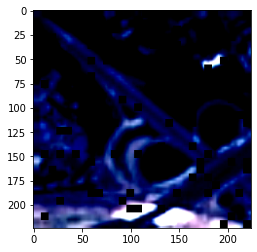

In [49]:
plt.imshow(images[2].permute(1,2,0))
plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
image_loss=nn.L1Loss()
triplet_loss_fn = nn.TripletMarginLoss(margin=1.5, p=2)
model = model.to(device)
epochs=20

recon_weight=5
n_times=15
alpha=0.01
best_accuracy = 0.0
for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_queries,total_final_psnr,total_final_recon_loss= 0,0,0,0,0

    from tqdm.notebook import tqdm
    progress_bar=tqdm(few_dataloader, desc=f"Epoch {epoch+1}/{epochs}",leave=False)

    total_recon_loss = 0
    total_psnr = 0

    for episode in progress_bar:
        images,mask,support_images, support_labels, query_images, query_labels=episode
        images = images.squeeze(0).to(device, non_blocking=True) 
        mask = mask.squeeze(0).to(device, non_blocking=True)
        support_images=(support_images.squeeze(0)).to(device, non_blocking=True)
        query_images=(query_images.squeeze(0)).to(device, non_blocking=True)
        support_labels=(support_labels.view(-1)).to(device, non_blocking=True)
        query_labels=(query_labels.view(-1)).to(device, non_blocking=True)
        
    
        total_combined_loss=0
        

        optimizer.zero_grad(set_to_none=True)
        all_triplet_loss=[]
        all_ce_losses = []
        all_query_logits = []
        all_psnr=[]
        all_reconstruct_loss=[]

        for _ in range(n_times):
            _,support_embeddings=model(support_images)
            _,query_embeddings=model(query_images)
            n_way=torch.unique(support_labels).size(0)
            prototypes=compute_prototypes(support_embeddings,support_labels,n_way)
            logits=classify_queries(prototypes,query_embeddings)
            ce_loss=loss_fn(logits,query_labels)

            all_ce_losses.append(ce_loss)
            all_query_logits.append(logits)

            anchor_embeddings = query_embeddings
            positive_embeddings = prototypes[query_labels] 

            dists = torch.cdist(anchor_embeddings, prototypes) # Shape: [num_queries, n_way]
            dists[torch.arange(len(query_labels)), query_labels] = float('inf')
            
            
            hard_negative_indices = torch.argmin(dists, dim=1)
            negative_embeddings = prototypes[hard_negative_indices].detach()

            
            triplet_loss = triplet_loss_fn(
                anchor_embeddings, 
                positive_embeddings, 
                negative_embeddings
            )




            reconstructed_image,_=model(images,mask)    
            recon_loss= masked_loss(reconstructed_image, support_images,mask)
            img_loss=image_loss(reconstructed_image,support_images)
            recon_loss+=img_loss
            mse_loss=F.mse_loss(reconstructed_image,support_images)
            psnr=compute_psnr(mse_loss, max_val=1.0)
            all_triplet_loss.append(triplet_loss)
            all_reconstruct_loss.append(recon_loss)
            all_psnr.append(psnr)

        total_triplet_loss = torch.stack(all_triplet_loss).mean()
        total_ce_loss= torch.stack(all_ce_losses).mean()
        stacked_logits=torch.stack(all_query_logits)
        stacked_probs=torch.softmax(stacked_logits,dim=-1)

        true_class_probs = stacked_probs[
            torch.arange(n_times)[:, None],
            torch.arange(len(query_labels)),
            query_labels
        ]

        total_recon_loss=torch.stack(all_reconstruct_loss).mean()
        total_psnr=torch.stack(all_psnr).mean()

        variance_loss=torch.std(true_class_probs,dim=0).sum()
        total_combined_loss=(recon_weight * total_recon_loss)+(total_ce_loss)+(alpha*variance_loss)+total_triplet_loss

        total_combined_loss.backward()
        optimizer.step()

        total_final_psnr+=total_psnr.item()
        total_final_recon_loss+=total_recon_loss.item()
        total_loss+=total_combined_loss.item()
        mean_logits=stacked_logits.mean(dim=0)
        preds=torch.argmax(mean_logits,dim=1)
        total_correct+=(preds==query_labels).sum().item()
        total_queries+=query_labels.size(0)

        avg_acc_till=(total_correct/total_queries)*100
        progress_bar.set_postfix(Phase="Training",Loss=f"{total_combined_loss.item():4f}",Acc=f"{avg_acc_till}",PSNR=f"{total_psnr.item():4f}&",Ce_Loss=f"{total_ce_loss.item():4f}",Recon_Loss=f"{total_recon_loss.item():4f}")

    
    avg_recon_loss = total_final_recon_loss / len(few_dataloader)
    avg_psnr = total_final_psnr / len(few_dataloader)
    avg_loss=total_loss/len(few_dataloader)
    accuracy=(total_correct/total_queries)*100
    print("Training ","Epoch:",epoch+1,"-------------","Loss=",avg_loss,"Acccuracy=",accuracy,"Recon Loss:",avg_recon_loss, "PSNR:",avg_psnr)



    model.eval()
    total_loss, total_correct, total_queries,total_final_psnr,total_final_recon_loss= 0,0,0,0,0
    from tqdm.notebook import tqdm
    progress_bar=tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{epochs}",leave=False)

    total_recon_loss = 0
    total_psnr = 0
    with torch.no_grad():
        for episode in progress_bar:
            images,mask,support_images, support_labels, query_images, query_labels=episode
            images = images.squeeze(0).to(device, non_blocking=True) 
            mask = mask.squeeze(0).to(device, non_blocking=True)
            support_images=(support_images.squeeze(0)).to(device, non_blocking=True)
            query_images=(query_images.squeeze(0)).to(device, non_blocking=True)
            support_labels=(support_labels.view(-1)).to(device, non_blocking=True)
            query_labels=(query_labels.view(-1)).to(device, non_blocking=True)
            

            total_combined_loss=0
            

            optimizer.zero_grad(set_to_none=True)
            #all_triplet_loss=[]
            all_ce_losses = []
            all_query_logits = []
            all_psnr=[]
            all_reconstruct_loss=[]
            model.train()
            for _ in range(n_times):
                _,support_embeddings=model(support_images)
                _,query_embeddings=model(query_images)
                n_way=torch.unique(support_labels).size(0)
                prototypes=compute_prototypes(support_embeddings,support_labels,n_way)
                logits=classify_queries(prototypes,query_embeddings)
                ce_loss=loss_fn(logits,query_labels)

                all_ce_losses.append(ce_loss)
                all_query_logits.append(logits)

                # anchor_embeddings = query_embeddings
                # positive_embeddings = prototypes[query_labels] 

                # dists = torch.cdist(anchor_embeddings, prototypes)
                # dists[torch.arange(len(query_labels)), query_labels] = float('inf')
                
                
                # hard_negative_indices = torch.argmin(dists, dim=1)
                # negative_embeddings = prototypes[hard_negative_indices].detach()

                
                # triplet_loss = triplet_loss_fn(
                #     anchor_embeddings, 
                #     positive_embeddings, 
                #     negative_embeddings
                # )

                reconstructed_image,_=model(images,mask)    
                recon_loss= masked_loss(reconstructed_image, support_images,mask)
                mse_loss=F.mse_loss(reconstructed_image,support_images)
                psnr=compute_psnr(mse_loss, max_val=1.0)
                #all_triplet_loss.append(triplet_loss)
                all_reconstruct_loss.append(recon_loss)
                all_psnr.append(psnr)
            model.eval()
            
            #total_triplet_loss = torch.stack(all_triplet_loss).mean()
            total_ce_loss= torch.stack(all_ce_losses).mean()
            stacked_logits=torch.stack(all_query_logits)
            stacked_probs=torch.softmax(stacked_logits,dim=-1)

            true_class_probs = stacked_probs[
                torch.arange(n_times)[:, None],
                torch.arange(len(query_labels)),
                query_labels
            ]

            total_recon_loss=torch.stack(all_reconstruct_loss).mean()
            total_psnr=torch.stack(all_psnr).mean()

            variance_loss=torch.std(true_class_probs,dim=0).sum()
            total_combined_loss=(recon_weight * total_recon_loss)+(total_ce_loss)+(alpha*variance_loss)#+total_triplet_loss


            total_final_psnr+=total_psnr.item()
            total_final_recon_loss+=total_recon_loss.item()
            total_loss+=total_combined_loss.item()
            mean_logits=stacked_logits.mean(dim=0)
            preds=torch.argmax(mean_logits,dim=1)
            total_correct+=(preds==query_labels).sum().item()
            total_queries+=query_labels.size(0)

            avg_acc_till=(total_correct/total_queries)*100
            progress_bar.set_postfix(Phase="Testing",Loss=f"{total_combined_loss.item():4f}",Acc=f"{avg_acc_till}",PSNR=f"{psnr}&")


        avg_recon_loss = total_final_recon_loss / len(few_dataloader)
        avg_psnr = total_final_psnr / len(few_dataloader)
        avg_loss=total_loss/len(few_dataloader)
        accuracy=(total_correct/total_queries)*100
        print("Testing ","Epoch:",epoch+1,"-------------","Loss=",avg_loss,"Acccuracy=",accuracy,"Recon Loss:",avg_recon_loss, "PSNR:",avg_psnr)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "/home/23dcs505/model_recon/3w5s_resnet.pth")


Epoch 1/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 1 ------------- Loss= 4.0383007216453555 Acccuracy= 97.63333333333334 Recon Loss: 0.7821736128628254 PSNR: 5.07102673381567


Epoch 1/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 1 ------------- Loss= 1.983726926445961 Acccuracy= 89.16666666666667 Recon Loss: 0.31042339608073233 PSNR: 5.628008312433958


Epoch 2/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 2 ------------- Loss= 2.8472041833400725 Acccuracy= 98.56666666666666 Recon Loss: 0.5510755217075348 PSNR: 6.880295068025589


Epoch 2/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 2 ------------- Loss= 1.7195258006453513 Acccuracy= 87.3 Recon Loss: 0.23248610954731702 PSNR: 6.6006508278846745


Epoch 3/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 3 ------------- Loss= 2.391548352241516 Acccuracy= 98.93333333333332 Recon Loss: 0.4676417477428913 PSNR: 7.814587554931641


Epoch 3/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 3 ------------- Loss= 1.3321819159388542 Acccuracy= 90.8 Recon Loss: 0.19702428609132766 PSNR: 7.335377453565598


Epoch 4/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 4 ------------- Loss= 2.2332909893989563 Acccuracy= 99.36666666666667 Recon Loss: 0.4375185172259808 PSNR: 8.211601579189301


Epoch 4/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 4 ------------- Loss= 1.2489919300377368 Acccuracy= 90.73333333333333 Recon Loss: 0.18430409334599973 PSNR: 7.654374024868011


Epoch 5/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 5 ------------- Loss= 2.1705174332857133 Acccuracy= 99.2 Recon Loss: 0.42504702165722846 PSNR: 8.323180522918701


Epoch 5/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 5 ------------- Loss= 1.3514857803285123 Acccuracy= 88.56666666666668 Recon Loss: 0.18005848661065102 PSNR: 7.692255158424377


Epoch 6/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 6 ------------- Loss= 2.1170076018571855 Acccuracy= 99.46666666666667 Recon Loss: 0.4167263224720955 PSNR: 8.411775012016296


Epoch 6/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 6 ------------- Loss= 1.195123817920685 Acccuracy= 90.86666666666666 Recon Loss: 0.17327356975525618 PSNR: 7.830337249040603


Epoch 7/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 7 ------------- Loss= 2.0440807336568834 Acccuracy= 99.56666666666666 Recon Loss: 0.403868078738451 PSNR: 8.596031193733216


Epoch 7/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 7 ------------- Loss= 1.1399965800344944 Acccuracy= 92.30000000000001 Recon Loss: 0.17498311500996352 PSNR: 7.794839870929718


Epoch 8/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 8 ------------- Loss= 2.032834756374359 Acccuracy= 99.23333333333333 Recon Loss: 0.3989154958724976 PSNR: 8.676225826740264


Epoch 8/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 8 ------------- Loss= 1.1090303573012352 Acccuracy= 91.0 Recon Loss: 0.16171942858025432 PSNR: 8.158589627742767


Epoch 9/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 9 ------------- Loss= 2.006769781112671 Acccuracy= 99.83333333333333 Recon Loss: 0.39832541555166245 PSNR: 8.706266255378724


Epoch 9/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 9 ------------- Loss= 1.2475215224921703 Acccuracy= 89.56666666666668 Recon Loss: 0.16523016236722468 PSNR: 8.069469661712647


Epoch 10/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 10 ------------- Loss= 1.9509480530023575 Acccuracy= 99.33333333333333 Recon Loss: 0.38222115658223627 PSNR: 8.9463419175148


Epoch 10/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 10 ------------- Loss= 1.1642993958294392 Acccuracy= 91.06666666666666 Recon Loss: 0.16694934636354447 PSNR: 7.965966687202454


Epoch 11/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 11 ------------- Loss= 1.9012557965517045 Acccuracy= 99.7 Recon Loss: 0.37537763208150865 PSNR: 9.01636343240738


Epoch 11/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 11 ------------- Loss= 1.1025998309254645 Acccuracy= 90.13333333333333 Recon Loss: 0.15158515620976687 PSNR: 8.450782899856568


Epoch 12/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 12 ------------- Loss= 1.8420465505123138 Acccuracy= 99.66666666666667 Recon Loss: 0.3647850689291954 PSNR: 9.213092079162598


Epoch 12/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 12 ------------- Loss= 1.0700178687274455 Acccuracy= 91.96666666666667 Recon Loss: 0.1573066930472851 PSNR: 8.258325667381287


Epoch 13/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 13 ------------- Loss= 1.82644588470459 Acccuracy= 99.66666666666667 Recon Loss: 0.36153386399149895 PSNR: 9.263159191608429


Epoch 13/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 13 ------------- Loss= 0.9864144149422646 Acccuracy= 91.8 Recon Loss: 0.1398265074007213 PSNR: 8.747682926654816


Epoch 14/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 14 ------------- Loss= 1.8025245612859726 Acccuracy= 99.83333333333333 Recon Loss: 0.3582868132740259 PSNR: 9.270542683601379


Epoch 14/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 14 ------------- Loss= 1.1043869063258172 Acccuracy= 90.66666666666666 Recon Loss: 0.1506063925474882 PSNR: 8.489371814727782


Epoch 15/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 15 ------------- Loss= 1.8060198098421096 Acccuracy= 99.86666666666667 Recon Loss: 0.3592589233070612 PSNR: 9.230748074054718


Epoch 15/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 15 ------------- Loss= 1.0628513289988042 Acccuracy= 91.26666666666667 Recon Loss: 0.15149463746696712 PSNR: 8.43296639919281


Epoch 16/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 16 ------------- Loss= 1.7805458420515061 Acccuracy= 99.93333333333332 Recon Loss: 0.3540394699573517 PSNR: 9.347691292762756


Epoch 16/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 16 ------------- Loss= 1.118795877546072 Acccuracy= 90.0 Recon Loss: 0.14561331951990725 PSNR: 8.70649361371994


Epoch 17/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 17 ------------- Loss= 1.7921775925159453 Acccuracy= 99.66666666666667 Recon Loss: 0.35377284526824954 PSNR: 9.340147850513459


Epoch 17/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 17 ------------- Loss= 1.0996746872365475 Acccuracy= 89.5 Recon Loss: 0.14697073914110662 PSNR: 8.565909523963928


Epoch 18/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 18 ------------- Loss= 1.7682100141048431 Acccuracy= 99.9 Recon Loss: 0.3518619305640459 PSNR: 9.357544198036194


Epoch 18/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 18 ------------- Loss= 1.2981715473532676 Acccuracy= 87.76666666666667 Recon Loss: 0.14107417225837707 PSNR: 8.722800295352936


Epoch 19/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 19 ------------- Loss= 1.7027508294582367 Acccuracy= 99.93333333333332 Recon Loss: 0.33789496757090093 PSNR: 9.619597301483154


Epoch 19/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 19 ------------- Loss= 1.0104717089235782 Acccuracy= 91.86666666666666 Recon Loss: 0.1435383502393961 PSNR: 8.676692478656769


Epoch 20/20:   0%|          | 0/200 [00:00<?, ?it/s]

Training  Epoch: 20 ------------- Loss= 1.7578331434726715 Acccuracy= 99.83333333333333 Recon Loss: 0.3481521698832512 PSNR: 9.420414011478424


Epoch 20/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing  Epoch: 20 ------------- Loss= 1.0311540926992893 Acccuracy= 91.53333333333333 Recon Loss: 0.1450863222591579 PSNR: 8.631778564453125


In [51]:
recon_weight

5

In [53]:
alpha

0.01

In [ ]:
model.load_state_dict(torch.load("/home/23dcs505/model_recon/3w5s_resnet.pth"))

In [58]:
model.eval()
total_loss, total_correct, total_queries,total_final_psnr,total_final_recon_loss= 0,0,0,0,0
from tqdm.notebook import tqdm
progress_bar=tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{epochs}",leave=False)

total_recon_loss = 0
total_psnr = 0
with torch.no_grad():
    for episode in progress_bar:
        images,mask,support_images, support_labels, query_images, query_labels=episode
        images = images.squeeze(0).to(device, non_blocking=True) 
        mask = mask.squeeze(0).to(device, non_blocking=True)
        support_images=(support_images.squeeze(0)).to(device, non_blocking=True)
        query_images=(query_images.squeeze(0)).to(device, non_blocking=True)
        support_labels=(support_labels.view(-1)).to(device, non_blocking=True)
        query_labels=(query_labels.view(-1)).to(device, non_blocking=True)
        

        total_combined_loss=0
        

        optimizer.zero_grad(set_to_none=True)
        all_ce_losses = []
        all_query_logits = []
        all_psnr=[]
        all_reconstruct_loss=[]
        model.train()
        for _ in range(n_times):
            _,support_embeddings=model(support_images)
            _,query_embeddings=model(query_images)
            n_way=torch.unique(support_labels).size(0)
            prototypes=compute_prototypes(support_embeddings,support_labels,n_way)
            logits=classify_queries(prototypes,query_embeddings)
            ce_loss=loss_fn(logits,query_labels)

            all_ce_losses.append(ce_loss)
            all_query_logits.append(logits)

            reconstructed_image,_=model(images,mask)    
            recon_loss= masked_loss(reconstructed_image, support_images,mask)
            mse_loss=F.mse_loss(reconstructed_image,support_images)
            psnr=compute_psnr(mse_loss, max_val=1.0)

            all_reconstruct_loss.append(recon_loss)
            all_psnr.append(psnr)
        model.eval()
        
        total_ce_loss= torch.stack(all_ce_losses).mean()
        stacked_logits=torch.stack(all_query_logits)
        stacked_probs=torch.softmax(stacked_logits,dim=-1)

        true_class_probs = stacked_probs[
            torch.arange(n_times)[:, None],
            torch.arange(len(query_labels)),
            query_labels
        ]

        total_recon_loss=torch.stack(all_reconstruct_loss).mean()
        total_psnr=torch.stack(all_psnr).mean()

        variance_loss=torch.std(true_class_probs,dim=0).sum()
        total_combined_loss=(recon_weight * total_recon_loss)+(total_ce_loss)+(alpha*variance_loss)

        #total_combined_loss.backward()
        #optimizer.step()

        total_final_psnr+=total_psnr.item()
        total_final_recon_loss+=total_recon_loss.item()
        total_loss+=total_combined_loss.item()
        mean_logits=stacked_logits.mean(dim=0)
        preds=torch.argmax(mean_logits,dim=1)
        total_correct+=(preds==query_labels).sum().item()
        total_queries+=query_labels.size(0)

        avg_acc_till=(total_correct/total_queries)*100
        progress_bar.set_postfix(Loss=f"{total_combined_loss.item():4f}",Acc=f"{avg_acc_till}",PSNR=f"{psnr}&")


    avg_recon_loss = total_final_recon_loss / len(few_dataloader)
    avg_psnr = total_final_psnr / len(few_dataloader)
    avg_loss=total_loss/len(few_dataloader)
    accuracy=(total_correct/total_queries)*100
    print("Testing On 10 Classes(Seen + Unseen)","Loss=",avg_loss,"Acccuracy=",accuracy,"Recon Loss:",avg_recon_loss, "PSNR:",avg_psnr)

Epoch 21/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing On 10 Classes(Seen + Unseen) Loss= 1.162133028358221 Acccuracy= 92.2 Recon Loss: 0.1765722483769059 PSNR: 7.745959513187408


In [60]:
model.eval()
total_loss, total_correct, total_queries,total_final_psnr,total_final_recon_loss= 0,0,0,0,0
from tqdm.notebook import tqdm
progress_bar=tqdm(strict_test_dataloader, desc=f"Epoch {epoch+1}/{epochs}",leave=False)

total_recon_loss = 0
total_psnr = 0
with torch.no_grad():
    for episode in progress_bar:
        images,mask,support_images, support_labels, query_images, query_labels=episode
        images = images.squeeze(0).to(device, non_blocking=True) 
        mask = mask.squeeze(0).to(device, non_blocking=True)
        support_images=(support_images.squeeze(0)).to(device, non_blocking=True)
        query_images=(query_images.squeeze(0)).to(device, non_blocking=True)
        support_labels=(support_labels.view(-1)).to(device, non_blocking=True)
        query_labels=(query_labels.view(-1)).to(device, non_blocking=True)
        

        total_combined_loss=0
        

        optimizer.zero_grad(set_to_none=True)
        all_ce_losses = []
        all_query_logits = []
        all_psnr=[]
        all_reconstruct_loss=[]
        model.train()
        for _ in range(n_times):
            _,support_embeddings=model(support_images)
            _,query_embeddings=model(query_images)
            n_way=torch.unique(support_labels).size(0)
            prototypes=compute_prototypes(support_embeddings,support_labels,n_way)
            logits=classify_queries(prototypes,query_embeddings)
            ce_loss=loss_fn(logits,query_labels)

            all_ce_losses.append(ce_loss)
            all_query_logits.append(logits)

            reconstructed_image,_=model(images,mask)    
            recon_loss= masked_loss(reconstructed_image, support_images,mask)
            mse_loss=F.mse_loss(reconstructed_image,support_images)
            psnr=compute_psnr(mse_loss, max_val=1.0)

            all_reconstruct_loss.append(recon_loss)
            all_psnr.append(psnr)
        model.eval()
        
        total_ce_loss= torch.stack(all_ce_losses).mean()
        stacked_logits=torch.stack(all_query_logits)
        stacked_probs=torch.softmax(stacked_logits,dim=-1)

        true_class_probs = stacked_probs[
            torch.arange(n_times)[:, None],
            torch.arange(len(query_labels)),
            query_labels
        ]

        total_recon_loss=torch.stack(all_reconstruct_loss).mean()
        total_psnr=torch.stack(all_psnr).mean()

        variance_loss=torch.std(true_class_probs,dim=0).sum()
        total_combined_loss=(recon_weight * total_recon_loss)+(total_ce_loss)+(alpha*variance_loss)

        #total_combined_loss.backward()
        #optimizer.step()

        total_final_psnr+=total_psnr.item()
        total_final_recon_loss+=total_recon_loss.item()
        total_loss+=total_combined_loss.item()
        mean_logits=stacked_logits.mean(dim=0)
        preds=torch.argmax(mean_logits,dim=1)
        total_correct+=(preds==query_labels).sum().item()
        total_queries+=query_labels.size(0)

        avg_acc_till=(total_correct/total_queries)*100
        progress_bar.set_postfix(Loss=f"{total_combined_loss.item():4f}",Acc=f"{avg_acc_till}",PSNR=f"{psnr}&")


    avg_recon_loss = total_final_recon_loss / len(few_dataloader)
    avg_psnr = total_final_psnr / len(few_dataloader)
    avg_loss=total_loss/len(few_dataloader)
    accuracy=(total_correct/total_queries)*100
    print("Testing On 5 Classes(Unseen)","Loss=",avg_loss,"Acccuracy=",accuracy,"Recon Loss:",avg_recon_loss, "PSNR:",avg_psnr)

Epoch 21/20:   0%|          | 0/200 [00:00<?, ?it/s]

Testing On 5 Classes(Unseen) Loss= 1.6212691295146942 Acccuracy= 81.03333333333333 Recon Loss: 0.20597668919712306 PSNR: 7.025152561664581


In [61]:
import matplotlib.pyplot as plt

def show_images(masked, recon, original):
    masked = masked.cpu().permute(1, 2, 0).numpy()
    recon = recon.cpu().permute(1, 2, 0).numpy()
    original = original.cpu().permute(1, 2, 0).numpy()
    

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(masked); axs[0].set_title('Masked Input'); axs[0].axis('off')
    axs[1].imshow(recon); axs[1].set_title('Reconstruction'); axs[1].axis('off')
    axs[2].imshow(original); axs[2].set_title('Original'); axs[2].axis('off')
    plt.show()


In [62]:
def compute_psnr(rmse, max_val=1.0):
    psnr = 20 * torch.log10(max_val / rmse)
    return psnr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


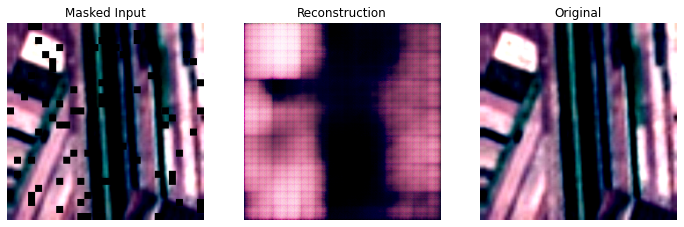

10.66910171508789


In [63]:
r=random.randint(1,5000)
model.eval()
with torch.no_grad():
    masked_img,mask,img,_,_,_ = few_dataset[10]  # Single sample
    masked_img = masked_img.to(device)  # [1, 3, 224, 224]
    mask = mask.to(device)              # [1, 1, 224, 224]
    img = img.to(device)

    recon,_ = model(masked_img, mask)                  # [1, 3, 224, 224]
    show_images(masked_img[0], recon[0], img[0])
    reconstruction_loss_fn = nn.L1Loss()
    recon_loss = reconstruction_loss_fn(recon[0],img[0])
    psnr=compute_psnr(recon_loss, max_val=1.0)
    print(psnr.item())       # Pass individual tensors to visualization
